# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

# from HANKModel import HANKModelClass
from HANKModel import create_model
import numpy as np
import matplotlib.pyplot as plt

# nice default style
plt.rcParams.update({
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
    "font.size": 12
})


## Q2: Compute the impact and cumulative multipliers in the RANK and the TANK model after a deficit-financed transfers 

### Solve for the steady-states

In [2]:
def compute_linear_multipliers(model, discount=None):
    if discount is None:
        discount = (1 + model.ss.r)**(-np.arange(model.par.T))
    model.compute_jacs(do_print=False)
    model.find_IRFs(shocks=['transfers'], do_print=False)

    dY = model.IRF['Y']
    dT = model.IRF['transfers']

    impact = dY[0] / dT[0]
    cumulative = np.sum(discount * dY) / np.sum(discount * dT)
    return impact, cumulative


In [3]:
model_RANK = create_model(name='RANK', par={'HH_type': 'RANK'})
model_TANK = create_model(name='TANK', par={'HH_type': 'TANK'})
model_RANK.par.low_transfers = False
model_TANK.par.low_transfers = False

model_RANK.par.beta = 0.99
model_RANK.find_ss(do_print=True)

model_TANK.par.beta = model_RANK.par.beta
model_TANK.find_ss(do_print=False, x0=np.array([model_TANK.par.beta]))

discount_RANK = (1 + model_RANK.ss.r)**(-np.arange(model_RANK.par.T))
discount_TANK = (1 + model_TANK.ss.r)**(-np.arange(model_TANK.par.T))

impact_multiplier_RANK, cumulative_multiplier_RANK = compute_linear_multipliers(model_RANK, discount_RANK)
impact_multiplier_TANK, cumulative_multiplier_TANK = compute_linear_multipliers(model_TANK, discount_TANK)

print(f"RANK Impact Multiplier: {impact_multiplier_RANK:.2f}")
print(f"RANK Cumulative Multiplier: {cumulative_multiplier_RANK:.2f}")
print(f"TANK Impact Multiplier: {impact_multiplier_TANK:.2f}")
print(f"TANK Cumulative Multiplier: {cumulative_multiplier_TANK:.2f}")


steady state found in 0.0 secs
 beta =   0.9735
 r    =   0.0050
 B   =   0.9200
Discrepancy in A =   0.00000000
Discrepancy in Y =  -0.00000000
steady state found in 0.0 secs
 beta =   0.9735
 r    =   0.0050
 B   =   0.9200
Discrepancy in A =   0.00000000
Discrepancy in Y =   0.00000000
RANK Impact Multiplier: 0.00
RANK Cumulative Multiplier: 0.00
TANK Impact Multiplier: 0.83
TANK Cumulative Multiplier: -0.00


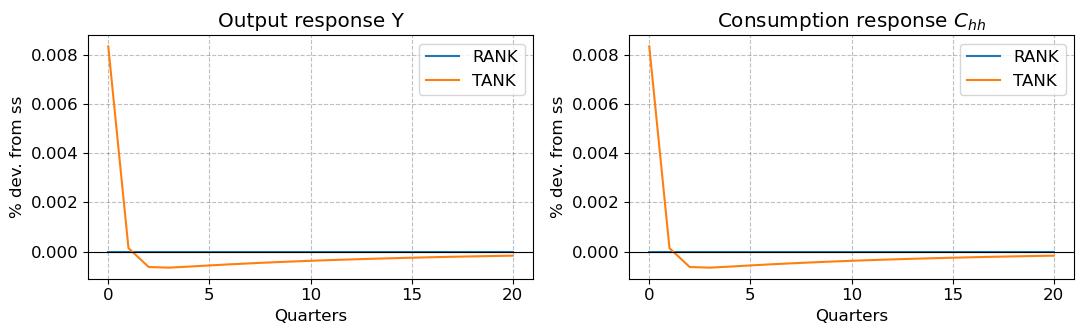

In [4]:
for m in [model_RANK, model_TANK]:
    m.compute_jacs(do_print=False)
    m.find_IRFs(shocks=['transfers'], do_print=False)

T_plot = 21
tgrid = np.arange(T_plot)

dY_RANK = model_RANK.IRF['Y'][:T_plot]
dY_TANK = model_TANK.IRF['Y'][:T_plot]
dC_RANK = model_RANK.IRF['C_hh'][:T_plot]
dC_TANK = model_TANK.IRF['C_hh'][:T_plot]

fig, ax = plt.subplots(1, 2, figsize=(11,3.5))

ax[0].plot(tgrid, dY_RANK, label='RANK')
ax[0].plot(tgrid, dY_TANK, label='TANK')
ax[0].axhline(0,color='black',linewidth=0.8)
ax[0].set_title('Output response Y')
ax[0].set_xlabel('Quarters')
ax[0].set_ylabel('% dev. from ss')
ax[0].legend()

ax[1].plot(tgrid, dC_RANK, label='RANK')
ax[1].plot(tgrid, dC_TANK, label='TANK')
ax[1].axhline(0,color='black',linewidth=0.8)
ax[1].set_title('Consumption response $C_{hh}$')
ax[1].set_xlabel('Quarters')
ax[1].set_ylabel('% dev. from ss')
ax[1].legend()

fig.tight_layout()
fig.savefig('q2.png', dpi=200)
plt.show()


## Q3: Impact and cumulative multipliers in HANK

### Solve for the steady-state

In [5]:
model_HANK = create_model(name='baseline', par={'HH_type': 'HANK'})
model_HANK.par.low_transfers = False
model_HANK.par.B = 0.92
model_HANK.find_ss(do_print=False)

impact_multiplier_HANK, cumulative_multiplier_HANK = compute_linear_multipliers(model_HANK)
print(f"HANK Impact Multiplier: {impact_multiplier_HANK:.2f}")
print(f"HANK Cumulative Multiplier: {cumulative_multiplier_HANK:.2f}")


steady state found in 2.3 secs
 beta =   0.9757
 r    =   0.0050
 B   =   0.9200
Discrepancy in A =   0.00000000
Discrepancy in Y =   0.00000000
HANK Impact Multiplier: 0.71
HANK Cumulative Multiplier: 1.04


### Compute multipliers

In [6]:
model_HANK_large = model_HANK.copy()
large_shock_size = 0.10           # 10% of output (as in assignment)
model_HANK_large.par.jump_transfers = large_shock_size
impact_multiplier_HANK_large, cumulative_multiplier_HANK_large = compute_linear_multipliers(model_HANK_large)

### Multipliers during a large shock

In [7]:

model_HANK_large.find_transition_path(shocks=['transfers'], do_print=False, do_end_check=False)
discount_large = (1 + model_HANK_large.ss.r)**(-np.arange(model_HANK_large.par.T))
dY_large = model_HANK_large.path.Y[:, 0] - model_HANK_large.ss.Y
dT_large = model_HANK_large.path.transfers[:, 0] - model_HANK_large.ss.transfers

impact_multiplier_HANK_large_nonlin = dY_large[0] / dT_large[0]
cumulative_multiplier_HANK_large_nonlin = (discount_large @ dY_large) / (discount_large @ dT_large)

print(f"HANK Large Shock Impact (Linear):     {impact_multiplier_HANK_large:.2f}")
print(f"HANK Large Shock Cumulative (Linear): {cumulative_multiplier_HANK_large:.2f}")
print(f"HANK Large Shock Impact (Non-linear): {impact_multiplier_HANK_large_nonlin:.2f}")
print(f"HANK Large Shock Cumulative (Non-lin):{cumulative_multiplier_HANK_large_nonlin:.2f}")


HANK Large Shock Impact (Linear):     0.71
HANK Large Shock Cumulative (Linear): 1.04
HANK Large Shock Impact (Non-linear): 0.27
HANK Large Shock Cumulative (Non-lin):0.97


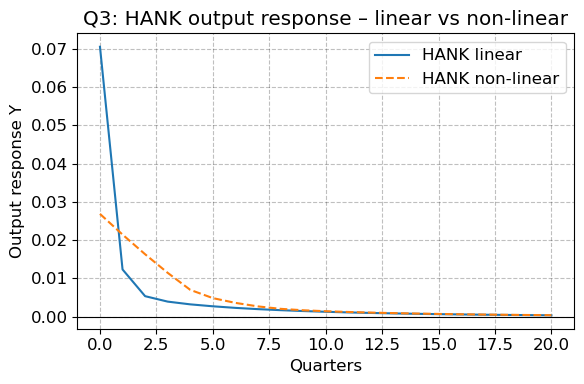

In [8]:
model_HANK_large.compute_jacs(do_print=False)
model_HANK_large.find_IRFs(shocks=['transfers'], do_print=False)
dY_lin = model_HANK_large.IRF['Y'][:T_plot]

# non-linear path (transition)
model_HANK_large.find_transition_path(shocks=['transfers'], do_print=False, do_end_check=False)
dY_nonlin = (model_HANK_large.path.Y[:,0] - model_HANK_large.ss.Y)[:T_plot]

plt.figure(figsize=(6,4))
plt.plot(tgrid, dY_lin, label='HANK linear')
plt.plot(tgrid, dY_nonlin, linestyle='--', label='HANK non-linear')
plt.axhline(0,color='black',linewidth=0.8)
plt.xlabel('Quarters')
plt.ylabel('Output response Y')
plt.title('Q3: HANK output response – linear vs non-linear')
plt.legend()
plt.tight_layout()
plt.savefig('q3.png', dpi=200)
plt.show()

## Q4: Multiplier with high-liquidity

### Compute multipliers

Aggregate annual MPC (HANK): 0.82


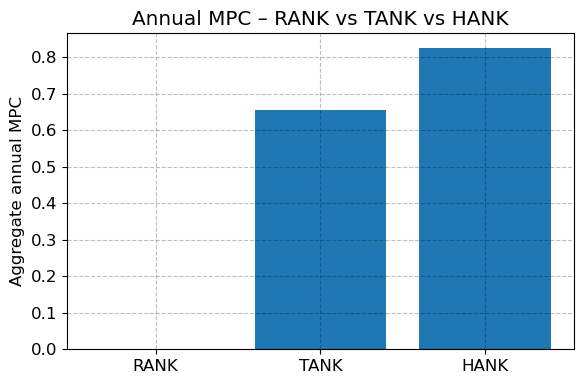

In [9]:
# === Q4: aggregate annual MPC helper ===
def aggregate_annual_mpc(model, T_yr=4):
    model.compute_jacs(do_print=False)
    model.find_IRFs(shocks=['transfers'], do_print=False)
    disc = model.par.beta**np.arange(T_yr)

    dC = model.IRF['C_hh'][:T_yr]
    dT = model.IRF['transfers'][:T_yr]
    return np.sum(disc * dC) / np.sum(disc * dT)


annual_MPC_HANK = aggregate_annual_mpc(model_HANK_large)
print(f"Aggregate annual MPC (HANK): {annual_MPC_HANK:.2f}")

mpc_RANK = aggregate_annual_mpc(model_RANK)
mpc_TANK = aggregate_annual_mpc(model_TANK)
mpc_HANK = aggregate_annual_mpc(model_HANK_large)

labels = ['RANK', 'TANK', 'HANK']
vals = [mpc_RANK, mpc_TANK, mpc_HANK]

plt.figure(figsize=(6,4))
plt.bar(labels, vals)
plt.ylabel('Aggregate annual MPC')
plt.title('Annual MPC – RANK vs TANK vs HANK')
plt.tight_layout()
plt.show()


In [10]:
model_RANK_hl = create_model(name='RANK', par={'HH_type': 'RANK'})
model_RANK_hl.par.low_transfers = False
model_RANK_hl.par.B = 16.0
model_RANK_hl.par.r = model_RANK.par.r
model_RANK_hl.find_ss(do_print=False, x0=np.array([model_RANK.par.beta]))
discount_RANK_hl = (1 + model_RANK_hl.ss.r)**(-np.arange(model_RANK_hl.par.T))
impact_multiplier_RANK_hl, cumulative_multiplier_RANK_hl = compute_linear_multipliers(model_RANK_hl, discount_RANK_hl)

model_TANK_hl = create_model(name='TANK', par={'HH_type': 'TANK'})
model_TANK_hl.par.low_transfers = False
model_TANK_hl.par.B = 16.0
model_TANK_hl.par.r = model_TANK.par.r
model_TANK_hl.find_ss(do_print=False, x0=np.array([model_TANK.par.beta]))
discount_TANK_hl = (1 + model_TANK_hl.ss.r)**(-np.arange(model_TANK_hl.par.T))
impact_multiplier_TANK_hl, cumulative_multiplier_TANK_hl = compute_linear_multipliers(model_TANK_hl, discount_TANK_hl)

model_HANK_hl = create_model(name='baseline', par={'HH_type': 'HANK'})
model_HANK_hl.par.low_transfers = False
model_HANK_hl.par.B = 16.0
model_HANK_hl.par.r = model_HANK.par.r
model_HANK_hl.find_ss(do_print=False, x0=np.array([model_HANK.par.beta]))
discount_HANK_hl = (1 + model_HANK_hl.ss.r)**(-np.arange(model_HANK_hl.par.T))
impact_multiplier_HANK_hl, cumulative_multiplier_HANK_hl = compute_linear_multipliers(model_HANK_hl, discount_HANK_hl)


steady state found in 0.0 secs
 beta =   0.9735
 r    =   0.0050
 B   =  16.0000
Discrepancy in A =   0.00000000
Discrepancy in Y =  -0.00000000
steady state found in 0.0 secs
 beta =   0.9735
 r    =   0.0050
 B   =  16.0000
Discrepancy in A =   0.00000000
Discrepancy in Y =  -0.00000000
steady state found in 7.1 secs
 beta =   0.9926
 r    =   0.0050
 B   =  16.0000
Discrepancy in A =   0.00000000
Discrepancy in Y =   0.00000000


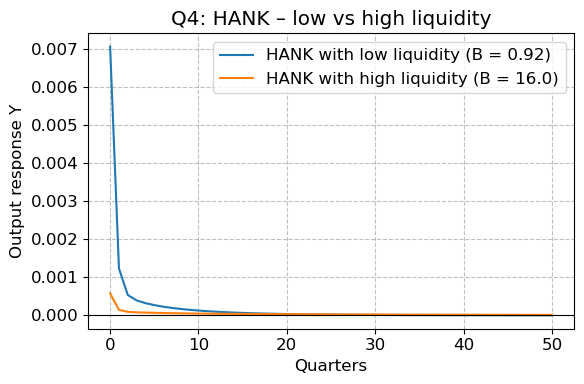

In [11]:
for m in [model_HANK, model_HANK_hl]:
    m.compute_jacs(do_print=False)
    m.find_IRFs(shocks=['transfers'], do_print=False)

T_plot_long = 51
tgrid_long = np.arange(T_plot_long)

dY_lowB  = model_HANK.IRF['Y'][:T_plot_long]
dY_highB = model_HANK_hl.IRF['Y'][:T_plot_long]

plt.figure(figsize=(6,4))
plt.plot(tgrid_long, dY_lowB,  label='HANK with low liquidity (B = 0.92)')
plt.plot(tgrid_long, dY_highB, label='HANK with high liquidity (B = 16.0)')
plt.axhline(0,color='black',linewidth=0.8)
plt.xlabel('Quarters')
plt.ylabel('Output response Y')
plt.title('Q4: HANK – low vs high liquidity')
plt.legend()
plt.tight_layout()
plt.savefig('q41.png', dpi=200)
plt.show()


### Plot iMPCs

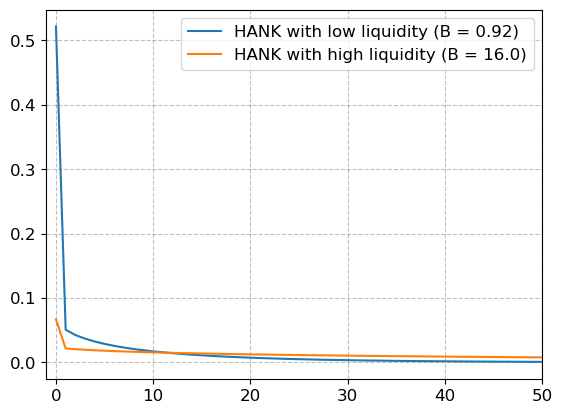

In [12]:
model_HANK.compute_jacs(do_print=False)
iMPC_low_liquidity = model_HANK.jac_hh[('C_hh', 'transfers')][:, 0]

model_HANK_hl.compute_jacs(do_print=False)
iMPC_high_liquidity = model_HANK_hl.jac_hh[('C_hh', 'transfers')][:, 0]

plt.plot(iMPC_low_liquidity, label='HANK with low liquidity (B = 0.92)')
plt.plot(iMPC_high_liquidity, label='HANK with high liquidity (B = 16.0)')
plt.xlim(-1, 50)
plt.legend()
plt.show()


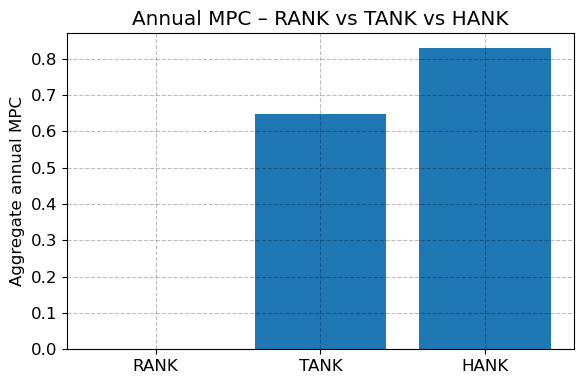

In [13]:
def aggregate_annual_mpc(model, T_yr=4):
    model.compute_jacs(do_print=False)
    model.find_IRFs(shocks=['transfers'], do_print=False)
    disc = (1 + model.ss.r)**(-np.arange(T_yr))
    dC = model.IRF['C_hh'][:T_yr]
    dT = model.IRF['transfers'][:T_yr]
    return np.sum(disc * dC) / np.sum(disc * dT)

mpc_RANK = aggregate_annual_mpc(model_RANK)
mpc_TANK = aggregate_annual_mpc(model_TANK)
mpc_HANK = aggregate_annual_mpc(model_HANK)

labels = ['RANK', 'TANK', 'HANK']
vals   = [mpc_RANK, mpc_TANK, mpc_HANK]

plt.figure(figsize=(6,4))
plt.bar(labels, vals)
plt.ylabel('Aggregate annual MPC')
plt.title('Annual MPC – RANK vs TANK vs HANK')
plt.tight_layout()
plt.savefig('q42.png', dpi=200)
plt.show()

## Q5: Targeted transfers

In [14]:
# === Targeted transfers and high kappa (Q5) ===
model_HANK_target = create_model(name='baseline', par={'HH_type': 'HANK'})
model_HANK_target.par.low_transfers = True
model_HANK_target.par.B = 16.0
model_HANK_target.par.r = model_HANK_hl.par.r
model_HANK_target.find_ss(do_print=False, x0=np.array([model_HANK_hl.par.beta]))
impact_multiplier_HANK_target, cumulative_multiplier_HANK_target = compute_linear_multipliers(model_HANK_target)

model_HANK_high_kappa = model_HANK_hl.copy()
model_HANK_high_kappa.par.kappa = 0.10
model_HANK_high_kappa.find_ss(do_print=False, x0=np.array([model_HANK_hl.par.beta]))
impact_multiplier_HANK_high_kappa, cumulative_multiplier_HANK_high_kappa = compute_linear_multipliers(model_HANK_high_kappa)


steady state found in 2.7 secs
 beta =   0.9926
 r    =   0.0050
 B   =  16.0000
Discrepancy in A =  -0.00000000
Discrepancy in Y =   0.00000000
steady state found in 2.2 secs
 beta =   0.9926
 r    =   0.0050
 B   =  16.0000
Discrepancy in A =  -0.00000000
Discrepancy in Y =   0.00000000


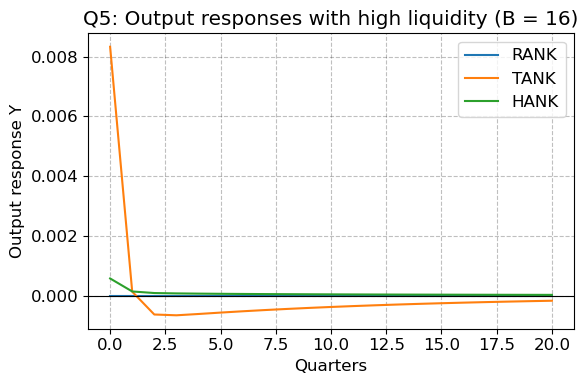

In [15]:
for m in [model_RANK_hl, model_TANK_hl, model_HANK_hl]:
    m.compute_jacs(do_print=False)
    m.find_IRFs(shocks=['transfers'], do_print=False)

dY_RANK_hl = model_RANK_hl.IRF['Y'][:T_plot]
dY_TANK_hl = model_TANK_hl.IRF['Y'][:T_plot]
dY_HANK_hl = model_HANK_hl.IRF['Y'][:T_plot]

plt.figure(figsize=(6,4))
plt.plot(tgrid, dY_RANK_hl, label='RANK')
plt.plot(tgrid, dY_TANK_hl, label='TANK')
plt.plot(tgrid, dY_HANK_hl, label='HANK')
plt.axhline(0,color='black',linewidth=0.8)
plt.xlabel('Quarters')
plt.ylabel('Output response Y')
plt.title('Q5: Output responses with high liquidity (B = 16)')
plt.legend()
plt.tight_layout()
plt.savefig('q51.png', dpi=200)
plt.show()

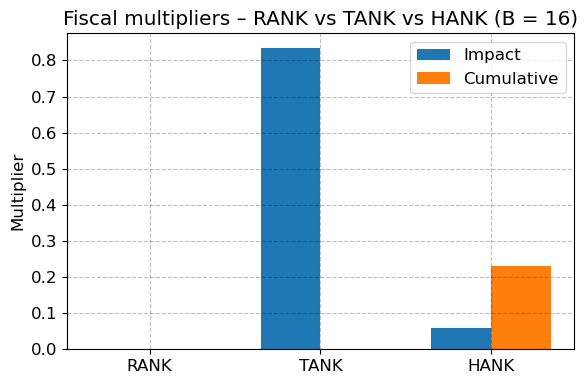

In [16]:
disc_RANK_hl = (1 + model_RANK_hl.ss.r)**(-np.arange(model_RANK_hl.par.T))
disc_TANK_hl = (1 + model_TANK_hl.ss.r)**(-np.arange(model_TANK_hl.par.T))
disc_HANK_hl = (1 + model_HANK_hl.ss.r)**(-np.arange(model_HANK_hl.par.T))

imp_RANK_hl, cum_RANK_hl = compute_linear_multipliers(model_RANK_hl, disc_RANK_hl)
imp_TANK_hl, cum_TANK_hl = compute_linear_multipliers(model_TANK_hl, disc_TANK_hl)
imp_HANK_hl, cum_HANK_hl = compute_linear_multipliers(model_HANK_hl, disc_HANK_hl)

labels = ['RANK', 'TANK', 'HANK']
impact = [imp_RANK_hl, imp_TANK_hl, imp_HANK_hl]
cumul  = [cum_RANK_hl, cum_TANK_hl, cum_HANK_hl]

x = np.arange(len(labels))
w = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - w/2, impact, width=w, label='Impact')
plt.bar(x + w/2, cumul,  width=w, label='Cumulative')
plt.xticks(x, labels)
plt.ylabel('Multiplier')
plt.title('Fiscal multipliers – RANK vs TANK vs HANK (B = 16)')
plt.legend()
plt.tight_layout()
plt.savefig('q52.png', dpi=200)
plt.show()


## Q6: Higher slope of NKPC

In [17]:
# --- Q6: HANK, B = 16, compare kappa = 0.03 vs 0.10 ---

# copy high-liquidity HANK (kappa = 0.03 baseline)
model_HANK_k003 = model_HANK_hl

# create version with higher kappa
model_HANK_k010        = model_HANK_hl.copy()
model_HANK_k010.name   = 'HANK_highliq_kappa010'
model_HANK_k010.par.kappa = 0.10
model_HANK_k010.find_ss(do_print=False, x0=np.array([model_HANK_hl.par.beta]))

# compute IRFs for both
for m in [model_HANK_k003, model_HANK_k010]:
    m.compute_jacs(do_print=False)
    m.find_IRFs(shocks=['transfers'], do_print=False)

# discount factors
disc_k003 = (1 + model_HANK_k003.ss.r)**(-np.arange(model_HANK_k003.par.T))
disc_k010 = (1 + model_HANK_k010.ss.r)**(-np.arange(model_HANK_k010.par.T))

# multipliers
imp_k003, cum_k003 = compute_linear_multipliers(model_HANK_k003, disc_k003)
imp_k010, cum_k010 = compute_linear_multipliers(model_HANK_k010, disc_k010)

print(f"kappa = 0.03  -> impact = {imp_k003:.3f}, cumulative = {cum_k003:.3f}")
print(f"kappa = 0.10  -> impact = {imp_k010:.3f}, cumulative = {cum_k010:.3f}")


steady state found in 2.1 secs
 beta =   0.9926
 r    =   0.0050
 B   =  16.0000
Discrepancy in A =  -0.00000000
Discrepancy in Y =   0.00000000
kappa = 0.03  -> impact = 0.058, cumulative = 0.231
kappa = 0.10  -> impact = 0.058, cumulative = 0.231


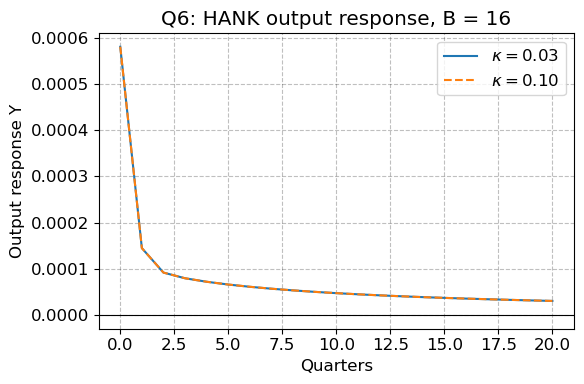

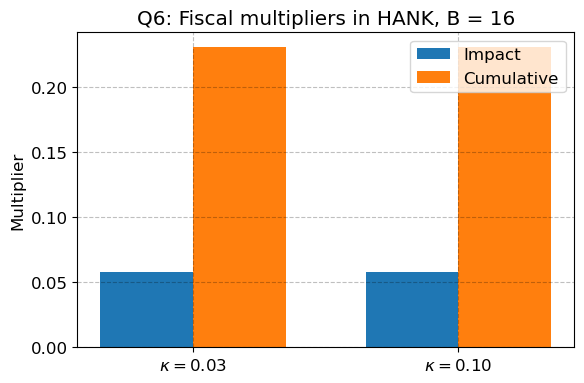

In [18]:
for m in [model_HANK_hl, model_HANK_high_kappa]:
    m.compute_jacs(do_print=False)
    m.find_IRFs(shocks=['transfers'], do_print=False)

disc_k003 = (1 + model_HANK_hl.ss.r)**(-np.arange(model_HANK_hl.par.T))
disc_k010 = (1 + model_HANK_high_kappa.ss.r)**(-np.arange(model_HANK_high_kappa.par.T))

imp_k003, cum_k003 = compute_linear_multipliers(model_HANK_hl,          disc_k003)
imp_k010, cum_k010 = compute_linear_multipliers(model_HANK_high_kappa, disc_k010)

# IRFs
dY_k003 = model_HANK_hl.IRF['Y'][:T_plot]
dY_k010 = model_HANK_high_kappa.IRF['Y'][:T_plot]

plt.figure(figsize=(6,4))
plt.plot(tgrid, dY_k003, label=r'$\kappa=0.03$')
plt.plot(tgrid, dY_k010, linestyle='--', label=r'$\kappa=0.10$')
plt.axhline(0,color='black',linewidth=0.8)
plt.xlabel('Quarters')
plt.ylabel('Output response Y')
plt.title('Q6: HANK output response, B = 16')
plt.legend()
plt.tight_layout()
plt.savefig('q61.png', dpi=200)
plt.show()

# multipliers bar
labels = [r'$\kappa=0.03$', r'$\kappa=0.10$']
impact = [imp_k003, imp_k010]
cumul  = [cum_k003, cum_k010]
x = np.arange(len(labels))
w = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - w/2, impact, width=w, label='Impact')
plt.bar(x + w/2, cumul,  width=w, label='Cumulative')
plt.xticks(x, labels)
plt.ylabel('Multiplier')
plt.title('Q6: Fiscal multipliers in HANK, B = 16')
plt.legend()
plt.tight_layout()
plt.savefig('q62.png', dpi=200)
plt.show()
